In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GloveWordEmbeddings/glove.twitter.27B.200d.txt
/kaggle/input/GloveWordEmbeddings/glove.6B.200d.txt
/kaggle/input/GloveWordEmbeddings/glove.twitter.27B.25d.txt
/kaggle/input/GloveWordEmbeddings/glove.twitter.27B.50d.txt
/kaggle/input/GloveWordEmbeddings/glove.6B.50d.txt
/kaggle/input/GloveWordEmbeddings/glove.twitter.27B.100d.txt
/kaggle/input/GloveWordEmbeddings/glove.6B.300d.txt
/kaggle/input/GloveWordEmbeddings/glove.840B.300d.txt
/kaggle/input/GloveWordEmbeddings/glove.6B.100d.txt
/kaggle/input/GloveWordEmbeddings/glove.42B.300d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import torch

import warnings
warnings.simplefilter('ignore')

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print("There are {} rows and {} columns in the train dataset".format
      (df_train.shape[0],df_train.shape[1]))
print("There are {} rows and {} columns in the test dataset".format
      (df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in the train dataset
There are 3263 rows and 4 columns in the test dataset


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
lst_train = []
for i in range(len(df_train)):
    lst_train.append(len(df_train['text'][i]))

lst_test = []
for i in range(len(df_test)):
    lst_test.append(len(df_test['text'][i]))

def Average(lst):
    return sum(lst)/len(lst)

In [10]:
print("The Average Number of words in all the sentences of our train dataset are {}".format(Average(lst_train)))
print("The Average Number of words in all the sentences of our test dataset are {}".format(Average(lst_test)))

The Average Number of words in all the sentences of our train dataset are 101.03743596479706
The Average Number of words in all the sentences of our test dataset are 102.10818265399939


Text(0.5, 1.0, 'Proportion of examples in our dataset')

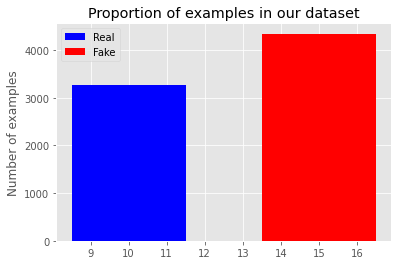

In [11]:
#df_train['target'].value_counts()

real_tweet = df_train[df_train['target']==1].shape[0]
fake_tweet = df_train[df_train['target']==0].shape[0]

plt.bar(10, real_tweet, 3, label="Real", color='blue')
plt.bar(15, fake_tweet, 3, label="Fake", color='Red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples in our dataset')

The method below is created to take out all the words from the training and test dataset based on the target column.

In [12]:
def create_corpus(target):
    corpus=[]

    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

The below piece of code helps us to extract all the stopwords from our training
dataset, for all the tweets which has Target=0. A bar chart is created post that to show the frequency of each stopword in the dataset.

In [13]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

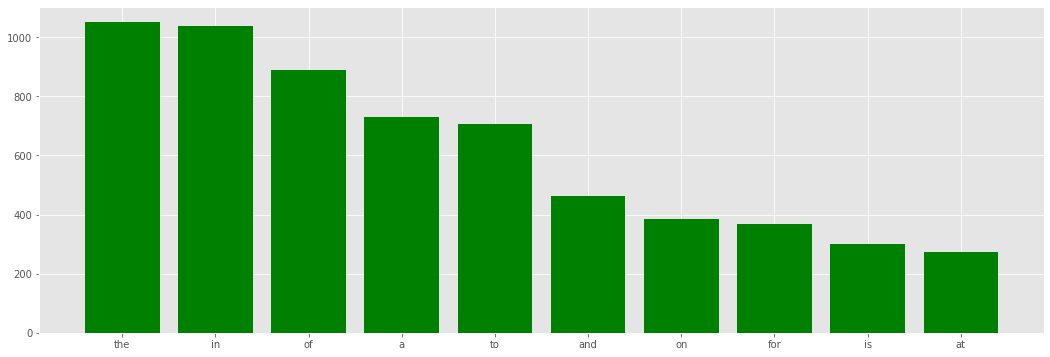

In [14]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y = zip(*top)
plt.bar(x,y, color='green')

Just like how we analyzed the stopwords for Target=0, we can perform the same steps for the tweets with Target=1.

<BarContainer object of 10 artists>

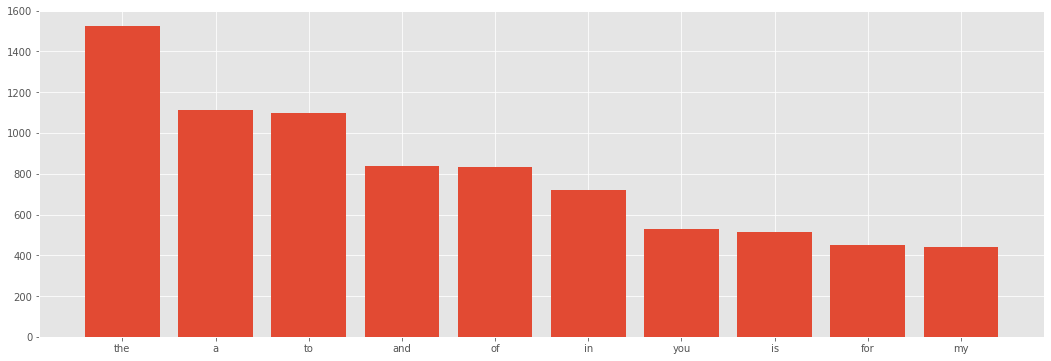

In [15]:
corpus = create_corpus(0)

dic = defaultdict(int) 
# Creates a dictionary of all words and doesn't return an error for words which
# are missing.

for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

We can analyze anything just the way we analyzed stopwords. Let's see how and what all punctuations are there in our training dataset for both Targets 1 & 0.

<BarContainer object of 18 artists>

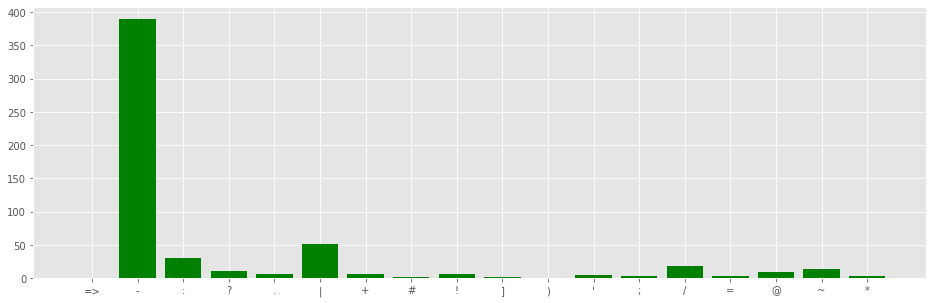

In [16]:
plt.figure(figsize=(16,5))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation # Returns all sets of punctuations in python.
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='green')

<BarContainer object of 20 artists>

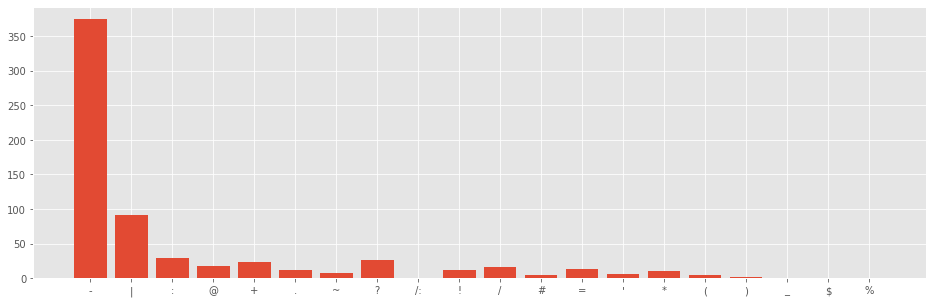

In [17]:
plt.figure(figsize=(16,5))
corpus = create_corpus(0)

dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [18]:
corpus = create_corpus(1) 
# Switch between 0 and 1 to see different word counts for Target=0/1.

plt.figure(figsize=(16,5))
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:>

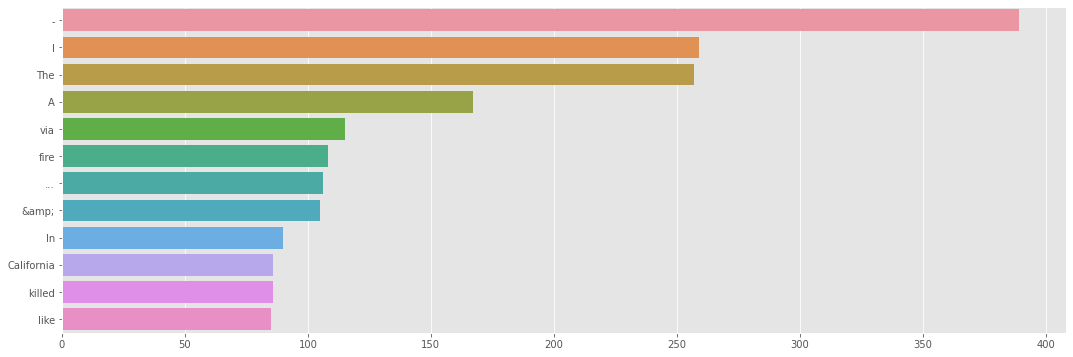

In [19]:
sns.barplot(x=y, y=x)

We can see that there is a lot of unnecessary junk data present in our dataset. We can clean all of that if we want to make a good Sentiment Classifier.
Also, we can look at Bigrams to identify what all junk values are occuring the most in our dataset. The function to extract the same is given below.

In [20]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

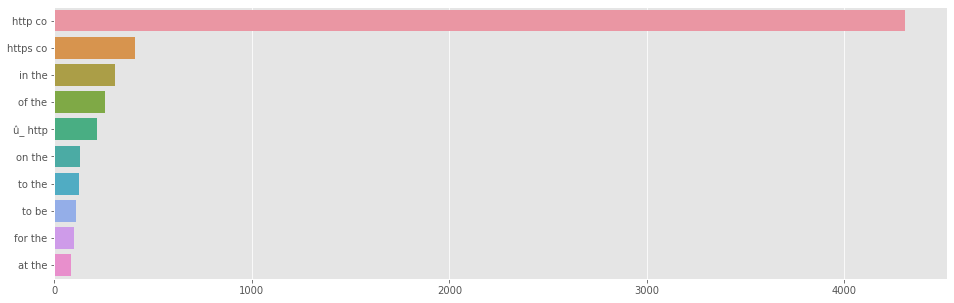

In [21]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

We can now move on to Data Cleaning and Pre-Processing.

The below piece of code removes the URLs from our tweets. This is very important as we don't want unnecessary URLs as they play no part in the Sentiment of our dataset.

In [22]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [23]:
df_train['text'] = df_train['text'].apply(lambda x: remove_URL(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_URL(x))

The below function helps us to remove any unwanted HTML tags that might be present in our dataset.

In [24]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [25]:
df_train['text'] = df_train['text'].apply(lambda x: remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_html(x))

The function below helps us to remove the emojis present, if any in our dataset.

In [26]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [27]:
df_train['text'] = df_train['text'].apply(lambda x: remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_emoji(x))

Use below function to remove Punctuations.

In [28]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [29]:
df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))

Below piece of code is used to remove the stopwords.

In [30]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text


df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))

In [31]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [32]:
df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))

In [33]:
%%time

def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [34]:
%%time
df_train['text'] = df_train['text'].apply(lambda x: clean(x))
df_test['text'] = df_test['text'].apply(lambda x: clean(x))

CPU times: user 7min 55s, sys: 210 ms, total: 7min 55s
Wall time: 7min 57s


In [35]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['hellfire we don\x89ûªt even want think mention let\x89ûªs anything leads islam',
 'hot  funtenna hijacking computers send data sound waves black hat   prebreak best',
 'choking hazard prompts recall of kraft cheese singles ',
 'drunk meals  what to cook when youre totally obliterated ',
 'star wars power of the jedi collection  battle droid hasbro  full read ebay  ',
 'bayelsa poll tension bayelsa patience jonathan plans hijack apc pdp plans former first lady ',
 'petition  heartless owner whipped horse collapsed told keep animal act now ',
 'i liked youtube video Justin Stuart  gun range mayhem',
 'how one careless match start forest fire takes whole box start campfire',
 'a look state actions year fergusons upheaval ',
 'that horrible sinking feeling you\x89ûªve home phone realise  whole time',
 'the way move like full rainstorm im house cards',
 'ignition knock detonation sensorsenso beckarnley   ',
 'hot  reddits new content policy goes effect many horrible subreddits banned quar

In [36]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [37]:
df_train.drop(columns=['target'], inplace=True)

In [38]:
df_train.rename(columns={'target_relabeled':'target'}, inplace=True)

In [39]:
#import re
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

#ps = PorterStemmer()
#corpus_train = []
#for i in range(0, len(df_train)):
#    review = re.sub('[^a-zA-Z]', ' ', df_train['text'][i])
#    review = review.lower()
#    review = review.split()
    
#    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#    review = ' '.join(review)
#    corpus_train.append(review)


#corpus_test = []
#for i in range(0, len(df_test)):
#    review = re.sub('[^a-zA-Z]', ' ', df_test['text'][i])
#    review = review.lower()
#    review = review.split()
    
#    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#    review = ' '.join(review)
#    corpus_test.append(review)


# COUNT VECTORIZER

In [40]:
# Creating the Bag of Words model
#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer()
#X = cv.fit_transform(corpus_train).toarray()

In [41]:
# Training model using Naive bayes classifier

#from sklearn.naive_bayes import MultinomialNB
#sentiment_detect_model = MultinomialNB().fit(X, df_train['target'])

In [42]:
#y = cv.transform(corpus_test)

In [43]:
#y_pred = sentiment_detect_model.predict(y)

In [44]:
#y_pred

In [45]:
#df_extract = pd.DataFrame()
#df_extract['id'] = df_test['id']
#df_extract['target'] = y_pred
#df_extract.to_csv('submission.csv',index=False)

Received a score of 0.77934 after submitting this output.

Update - I performed all the data cleaning steps (removing URLs, punctuations, etc.) and then re-ran this same model. This time I received a score of 0.79098. We can clearly see the improvement in our model after cleaning the dataset with the same model for Count Vectorizer.

No let's try with TF-IDF now and see if we can improve our score.

# TF-IDF

In [46]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidfv = TfidfVectorizer()
#tfidf_fit = tfidfv.fit_transform(corpus_train).toarray()

In [47]:
# Training model using Naive bayes classifier

#from sklearn.naive_bayes import MultinomialNB
#sentiment_detect_model_tfidf = MultinomialNB().fit(tfidf_fit, df_train['target'])

In [48]:
#y = tfidfv.transform(corpus_test)

In [49]:
#y_pred_tfidf = sentiment_detect_model_tfidf.predict(y)

In [50]:
#y_pred_tfidf

In [51]:
#df_extract = pd.DataFrame()
#df_extract['id'] = df_test['id']
#df_extract['target'] = y_pred_tfidf
#df_extract.to_csv('submission.csv',index=False)

Received a score of 0.78853 with this model.

Update - I performed all the data cleaning steps (removing URLs, punctuations, etc.) and then re-ran this same model. This time I received a score of 0.7965. We can clearly see the improvement in our model after cleaning the dataset with the same model for TF-IDF Vectorizer.

# TF-IDF WITH N-GRAM

In [52]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidfv = TfidfVectorizer(ngram_range=(1,3))
#tfidf_fit_n = tfidfv.fit_transform(corpus_train).toarray()

In [53]:
#tfidf_fit_n

In [54]:
# Training model using Naive bayes classifier

#from sklearn.naive_bayes import MultinomialNB
#sentiment_detect_model_tfidf_n = MultinomialNB().fit(tfidf_fit_n, df_train['target'])

In [55]:
#y = tfidfv.transform(corpus_test)

In [56]:
#y_pred_tfidf_n = sentiment_detect_model_tfidf_n.predict(y)

In [57]:
#y_pred_tfidf_n

In [58]:
#df_extract = pd.DataFrame()
#df_extract['id'] = df_test['id']
#df_extract['target'] = y_pred_tfidf_n
#df_extract.to_csv('./submission.csv',index=False)

Received a score of 0.79987 with this model.

Update - I performed all the data cleaning steps (removing URLs, punctuations, etc.) and then re-ran this same model. This time I received a score of 0.8014. We can clearly see the improvement in our model after cleaning the dataset with the same model for N-GRAM TF-IDF Vectorizer.

Update 2 - After performing some more cleaning steps, the score increased to 0.80386.

# WORD EMBEDDINGS USING TOKENIZATION

In [59]:
#tokenizer = Tokenizer(oov_token = "<OOV>", num_words = 500)
#tokenizer.fit_on_texts(corpus_train)
#word_index = tokenizer.word_index
#sequences = tokenizer.texts_to_sequences(corpus_train)

# print(word_index) Returns a dictionary with each word as a 'KEY' and a number for
# that corresponding word as a 'VALUE'.

# print(sequences) This returns the same value that we created using 
# tokenizer.fit_on_texts, not as a dictionary, but as a vector with 
# corresponding number assigned to that word. So we can basically create a word
# embedding for a corpus of texts, obtain a dictionary, and then re-use it to
# convert other words into sequences of vectors.

In [60]:
#vocab = len(word_index)
#print(vocab)

In [61]:
#max_len = max([len(i) for i in sequences])
#print(max_len)

In [62]:
#padded = pad_sequences(sequences, maxlen = max_len) # Helps us to pad our vectors to same length.

In [63]:
# Our padded word vectors have a maximum length of 23, that means there are not more
# than 23 words in a sentence. Also, we have a total of 7613 sentences.
#padded.shape

In [64]:
#import tensorflow as tf
#print(tf.__version__)

In [65]:
#model = Sequential([
#    tf.keras.layers.Embedding(vocab, 100 , input_length = 17), 

    # input_dim(Size of the vocabulary) = vocab
    # output_dim(Dimension of the Dense Embeddings) = 100    
    
#    tf.keras.layers.LSTM(128, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [66]:
#num_epochs = 40
#model.fit(padded, df_train['target'].values,
 #        epochs = num_epochs)

In [67]:
#sequences_test = tokenizer.texts_to_sequences(corpus_test)
#padded_test = pad_sequences(sequences_test, maxlen = max_len)

In [68]:
#pred = model.predict(padded_test).round(0)

In [69]:
#pred

In [70]:
#df_extract = pd.DataFrame()
#df_extract['id'] = df_test['id']
#df_extract['target'] = pred
#df_extract['target'] = df_extract['target'].astype(int)
#df_extract.to_csv('submission.csv',index=False)

After running and submitting the output file, I received a score of 0.74226. This is lower as compared to the score we obtained using the N-Gram TF-IDF, which is our highest score till now.

# GlOVE

In [71]:
#import re
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

#ps = PorterStemmer()
#corpus_train = []
#for i in range(0, len(df_train)):
#    review = re.sub('[^a-zA-Z]', ' ', df_train['text'][i])
#    review = review.lower()
#    review = review.split()
    
#    review = [word for word in review if word not in stopwords.words('english')]
#    review = ' '.join(review)
#    corpus_train.append(review)  

#corpus_test = []
#for i in range(0, len(df_test)):
#    review = re.sub('[^a-zA-Z]', ' ', df_test['text'][i])
#    review = review.lower()
#    review = review.split()
    
 #   review = [word for word in review if word not in stopwords.words('english')]
 #   review = ' '.join(review)
 #   corpus_test.append(review)  

We have pre-processed our dataset like we did before just with a slight difference. This time we are not going to apply Stemming as the words are changed and the Glove word embeddings might not be able to pick-up some meaningful words.

In [72]:
#tokenizer = Tokenizer(oov_token = "<OOV>", num_words = 500)
#tokenizer.fit_on_texts(corpus_train)
#word_index = tokenizer.word_index

#sequences = tokenizer.texts_to_sequences(corpus_train)

In [73]:
#voc = word_index.keys()

In [74]:
#vocab = len(word_index)+2
#max_len = max([len(i) for i in sequences])
#print(vocab)

In [75]:
#padded = pad_sequences(sequences, maxlen = max_len)

In [76]:
#sequences_test = tokenizer.texts_to_sequences(corpus_test)
#padded_test = pad_sequences(sequences_test, maxlen = max_len)

https://keras.io/examples/nlp/pretrained_word_embeddings/

In [77]:
#path_to_glove_file = "../input/GloveWordEmbeddings/glove.42B.300d.txt"

#embeddings_index = {}
#with open(path_to_glove_file) as f:
#    for line in f:
#        word, coefs = line.split(maxsplit=1)
#        coefs = np.fromstring(coefs, "f", sep=" ")
#        embeddings_index[word] = coefs

#print("Found %s word vectors." % len(embeddings_index))

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [78]:
#num_tokens = len(voc) + 2
#embedding_dim = 300
#hits = 0
#misses = 0

# Prepare embedding matrix
#embedding_matrix = np.zeros((num_tokens, embedding_dim))
#for word, i in word_index.items():
#    embedding_vector = embeddings_index.get(word)
#    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
#        embedding_matrix[i] = embedding_vector
#        hits += 1
#    else:
#        misses += 1
#print("Converted %d words (%d misses)" % (hits, misses))

In [79]:
#embedding_matrix.shape

In [80]:
#model = Sequential([
#   tf.keras.layers.Embedding(vocab, 300 , 
#       embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
#       input_length = 17, trainable = False),

    # input_dim(Size of the vocabulary) = vocab
    # output_dim(Dimension of the Dense Embeddings) = 100    
    
#    tf.keras.layers.LSTM(128, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

Model - 1) Above we have created a model withan embedding layer which is initialized using the pre-trained Glove embeddings, followed by a LSTM layer and a Dense layer.

In [81]:
#model = Sequential([
#   tf.keras.layers.Embedding(vocab, 300, 
#       embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
#       input_length = 17, trainable = False), 

    # input_dim(Size of the vocabulary) = vocab
    # output_dim(Dimension of the Dense Embeddings) = 100    
    
#    tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
#    tf.keras.layers.Bidirectional(LSTM(128)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

Model - 2) Here we have defined another model. This also starts with an embedding layer, followed by 2 BRNN layers, and BatchNorm layer, Dropout layer and a Dense layer at the end to get the final output.

In [82]:
#def glove_lstm():
#    model = Sequential()
    
#    model.add(Embedding(
#        input_dim=embedding_matrix.shape[0], 
#        output_dim=embedding_matrix.shape[1], 
#        weights = [embedding_matrix], 
#        input_length=17
#    ))
    
 #   model.add(tf.keras.layers.Bidirectional(LSTM(
 #       128, 
 #       return_sequences = True, 
 #       recurrent_dropout=0.2
 #   )))
    
 #   model.add(tf.keras.layers.GlobalMaxPool1D())
 #   model.add(tf.keras.layers.BatchNormalization())
 #   model.add(tf.keras.layers.Dropout(0.5))
 #   model.add(tf.keras.layers.Dense(128, activation = "relu"))
 #   model.add(tf.keras.layers.Dropout(0.5))
 #   model.add(Dense(128, activation = "relu"))
 #   model.add(tf.keras.layers.Dropout(0.5))
 #   model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
 #   model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
 #   return model

#model = glove_lstm()
#model.summary()

In [83]:
#num_epochs = 40
#model.fit(padded, df_train['target'].values,
#         epochs = num_epochs)

Model - 3) I'm tired with all the typing, but above is the 3rd model defined.

In [84]:
#pred = model.predict(padded_test).round(0)

In [85]:
#pred

In [86]:
#df_extract = pd.DataFrame()
#df_extract['id'] = df_test['id']
#df_extract['target'] = pred
#df_extract['target'] = df_extract['target'].astype(int)
#df_extract.to_csv('./submission.csv',index=False)

On creating a new model with Glove word embeddings trained on 840B, 300D data, I got a score of 0.75237.
Update: After performing a little more pre-processing, the scored improved to 76.585.

https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

# NEW BERT MODEL

In [87]:
!pip install GPUtil

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=c228f4731aa924719806f3dc27851b528e9062539951bc803dbdf263891a5b4d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [88]:
from torch import nn
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

In [89]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

In [90]:
from torch import nn
from transformers import AdamW, BertConfig, BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

In [91]:
# select device
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [92]:
X_train = df_train["text"].values
y_train = df_train["target"].values

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

lens = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [94]:
sequence_length = 58
# X_train_tokens[i] := sequence of sequence_length many tokens that represent text_{i}
X_train_tokens = []

for text in X_train:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True, # special tokens for BERT
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt', # pytorch tensor format
                                         truncation=True)
    X_train_tokens.append(encoded_dict['input_ids'])

In [95]:
# pytorch expects tensors
X_train_tokens = torch.cat(X_train_tokens, dim=0) # concat into one tensor

y_train = torch.tensor(y_train)

In [96]:
# tokenization of the first observation in the training set
# zero-padding is added
print('Original:\n', X_train[5])
print('Tokenization:\n', X_train_tokens[5])

Original:
 rockyfire update  california hwy  closed directions due lake county fire  cafire wildfires
Tokenization:
 tensor([  101,  6857, 10273, 10651,  2662,  1044, 18418,  2701,  7826,  2349,
         2697,  2221,  2543, 24689,  7442,  3748, 26332,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])


In [97]:
batch_size = 32

# split into training and validation data
dataset = TensorDataset(X_train_tokens, y_train.float())

train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

In [98]:
for batch in train_dataloader:
    print("what is drawn from our dataloader? ", type(batch))
    
    print("\nfirst entry: ", batch[0].size(), type(batch[0]), batch[0].dtype)
    print("\nsecond entry: ", batch[1].size(), type(batch[1]), batch[1].dtype)
    
    break

what is drawn from our dataloader?  <class 'list'>

first entry:  torch.Size([32, 58]) <class 'torch.Tensor'> torch.int64

second entry:  torch.Size([32]) <class 'torch.Tensor'> torch.float32


In [99]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

for batch in train_dataloader: 
    batch_features = batch[0].to(device)
    bert_output = bert(input_ids=batch_features) 
    
    print("bert output: ", type(bert_output), len(bert_output))
    
    print("first entry: ", type(bert_output[0]), bert_output[0].size())
    
    print("second entry: ", type(bert_output[1]), bert_output[1].size())
    
    break

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 58, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


In [100]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased') # returns pwerful representations of the microblogs
        self.linear = nn.Linear(768, 1) # custom layer; input of the first custom layer has to match the dimensionality of the BERT-output; further custom layers are possible
        self.sigmoid = nn.Sigmoid() # activation function applied to our custom layer to obtain probabilities
    
    def forward(self, tokens):
        bert_output = self.bert(input_ids=tokens)
        linear_output = self.linear(bert_output[1])
        proba = self.sigmoid(linear_output)
        return proba

In [101]:
def eval(y_batch, probas):
    
    preds_batch_np = np.round(probas.cpu().detach().numpy())
    
    y_batch_np = y_batch.cpu().detach().numpy()
    
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    
    return acc, f1

In [102]:
def train(model, optimizer, scheduler, epochs, name):
    history = []
    best_f1 = 0
    model.train()
    
    for epoch in range(epochs):
        
        # ===== train =====
        print("=== Epoch: ", epoch+1, " / ", epochs, " ===")
        acc_total = 0
        f1_total = 0
        
        for it, batch in enumerate(train_dataloader): 
            
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)] # draw the batch
            
            probas = torch.flatten(model(tokens=x_batch))
            
            acc_f1_batch = eval(y_batch, probas)
            
            acc_total, f1_total = acc_total + acc_f1_batch[0], f1_total + acc_f1_batch[1]
            
            model.zero_grad() # reset the gradients
            
            loss_func = nn.BCELoss()
            
            batch_loss = loss_func(probas, y_batch)
            
            batch_loss.backward() # calculate gradient per (learnable) weight
            
            optimizer.step() # update (learnable) weights
            
            scheduler.step() # update learning rate
            
        acc_total = acc_total/len(train_dataloader) #len(train dataloader)=num_batches
        
        f1_total = f1_total/len(train_dataloader)
        
        print("accuracy: ", acc_total, "\nf1: ", f1_total)
        
        

        # ===== validate =====
        acc_val_total = 0
        f1_val_total = 0
        
        for batch in validation_dataloader:
            
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
            
            with torch.no_grad(): # gradients don't have to be computed, because no update is performed
                probas = torch.flatten(model(tokens=x_batch))
            acc_f1_val_batch = eval(y_batch, probas)
            
            acc_val_total, f1_val_total = acc_val_total + acc_f1_val_batch[0], f1_val_total + acc_f1_val_batch[1]
            
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        
        print("validation accuracy: ", acc_val_total, "\nvalidation f1: ", f1_val_total, "\n")
        if(f1_val_total>best_f1): # save current mdoel if this epoch improved models validation performance 
            torch.save(model, name+".pt")
            best_f1 = f1_val_total

        history.append({"acc":acc_total, "f1":f1_total, "acc_val":acc_val_total, "f1_val":f1_val_total})
    return [torch.load(name+".pt"), history]

In [103]:
epochs = 10

baseline_bert_clf = BertClassifier()

baseline_bert_clf = baseline_bert_clf.to(device)

adam = AdamW(baseline_bert_clf.parameters(), lr=5e-5, eps=1e-8)

total_steps = len(train_dataloader) * epochs

sched = get_linear_schedule_with_warmup(adam, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [104]:
baseline_bert_clf, history = train(model=baseline_bert_clf,
                                   optimizer=adam,
                                   scheduler=sched,
                                   epochs=10,
                                   name="baseline_bert_clf")

=== Epoch:  1  /  10  ===
accuracy:  0.7774541884816755 
f1:  0.7690395449220332
validation accuracy:  0.8293928179824562 
validation f1:  0.8292419850639559 

=== Epoch:  2  /  10  ===
accuracy:  0.8612565445026178 
f1:  0.8589383675583961
validation accuracy:  0.8278166118421053 
validation f1:  0.8203673370873105 

=== Epoch:  3  /  10  ===
accuracy:  0.9170484293193717 
f1:  0.9160066111394928
validation accuracy:  0.8367598684210527 
validation f1:  0.8351104461712224 

=== Epoch:  4  /  10  ===
accuracy:  0.9490837696335079 
f1:  0.9488788387307006
validation accuracy:  0.8256921600877193 
validation f1:  0.8250192402642275 

=== Epoch:  5  /  10  ===
accuracy:  0.9641034031413613 
f1:  0.9639346452582296
validation accuracy:  0.8241502192982456 
validation f1:  0.8215904274452726 

=== Epoch:  6  /  10  ===
accuracy:  0.9719895287958116 
f1:  0.9719793513735764
validation accuracy:  0.8174342105263158 
validation f1:  0.8170394420955273 

=== Epoch:  7  /  10  ===
accuracy:  0.9

In [105]:
history_df = pd.DataFrame(history)

history_df

,acc,f1,acc_val,f1_val
0,0.777454,0.769040,0.829393,0.829242
1,0.861257,0.858938,0.827817,0.820367
2,0.917048,0.916007,0.836760,0.835110
3,0.949084,0.948879,0.825692,0.825019
4,0.964103,0.963935,0.824150,0.821590
5,0.971990,0.971979,0.817434,0.817039
6,0.977749,0.977736,0.822882,0.822741
7,0.980334,0.980204,0.810478,0.810508
8,0.983148,0.983151,0.823122,0.822141
9,0.983442,0.983437,0.819387,0.818913


In [106]:
X_test_tokens = []

for text in df_test['text'].values:
    
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt',
                                         truncation=True)
    
    X_test_tokens.append(encoded_dict['input_ids'])
    
    
    
X_test_tokens = torch.cat(X_test_tokens, dim=0)



test_set = TensorDataset(X_test_tokens)

test_dataloader = DataLoader(test_set, 
                             sampler=SequentialSampler(test_set), 
                             batch_size=batch_size)

In [107]:
all_preds = []

for batch in test_dataloader:
    x_batch = batch[0].to(device)
    with torch.no_grad():
        probas = baseline_bert_clf(tokens=x_batch)
    preds = np.round(probas.cpu().detach().numpy()).astype(int).flatten()
    all_preds.extend(preds)

In [108]:
challenge_pred = pd.concat([pd.read_csv("../input/nlp-getting-started/sample_submission.csv")["id"], pd.Series(all_preds)], axis=1)
challenge_pred.columns = ['id', 'target']
challenge_pred.to_csv("submission.csv", index=False)